# Multi-Head attention

1. Visualization of attention matrices $Q\cdot K^T$
2. Analysis of matrix symmetry

In [1]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 1. Visualization of attention matrices

/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/Users/miriamzara/LCP_B_GPT2/my_venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:820: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


Prompt: The italian flag's colors are red, white and

Layer  1: Entropy = 0.0345
   1:       Ġthe (0.9970)
   2:         Ġa (0.0018)
   3:          / (0.0006)
   4:         Ġ" (0.0002)
   5:         ĠI (0.0001)
   6:      Ġthen (0.0001)
   7:     Ġother (0.0001)
   8:          , (0.0000)
   9:        Ġin (0.0000)
  10:       Ġand (0.0000)
  11:          Ċ (0.0000)
  12:        Ġis (0.0000)
  13:        Ġan (0.0000)
  14:          - (0.0000)
  15:        Ġit (0.0000)
Layer  2: Entropy = 0.9767
   1:       Ġthe (0.8089)
   2:          / (0.0964)
   3:      Ġthen (0.0772)
   4:     Ġother (0.0147)
   5:         Ġa (0.0015)
   6:         ĠI (0.0010)
   7:         Ġ" (0.0001)
   8:  Ġpossibly (0.0001)
   9:        Ġso (0.0000)
  10:      Ġeven (0.0000)
  11:          , (0.0000)
  12:        Ġit (0.0000)
  13:        Ġin (0.0000)
  14:        Ġan (0.0000)
  15:        Ġis (0.0000)
Layer  3: Entropy = 0.7119
   1:       Ġthe (0.8669)
   2:          / (0.0912)
   3:      Ġthen (0.0374)
   4:  

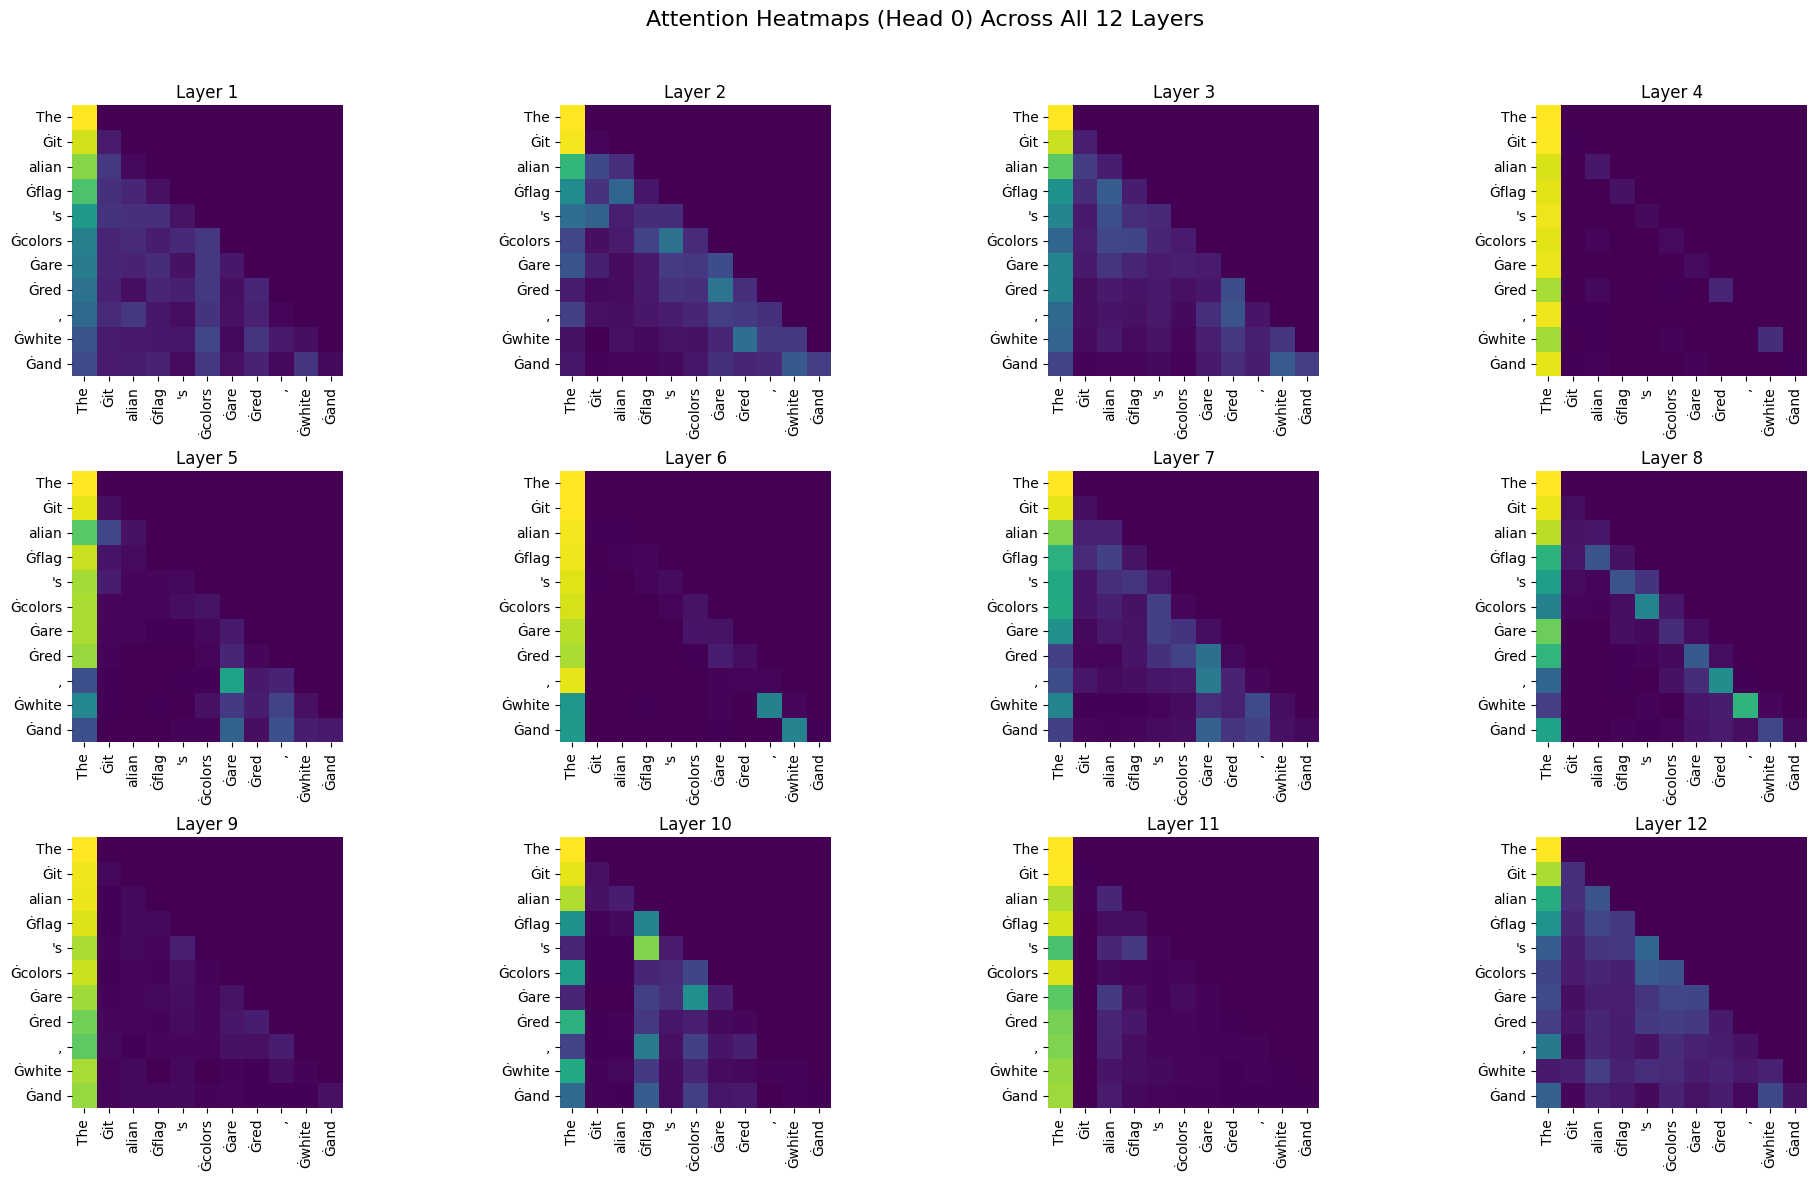

In [ ]:
model = AutoModelForCausalLM.from_pretrained("gpt2", output_attentions=True, output_hidden_states=True)
tokenizer = AutoTokenizer.from_pretrained("gpt2")                     #trasforma input in token
model.eval() # set in evaluation mode (no dropout)

# Input text
prompt = "The italian flag's colors are red, white and"
inputs = tokenizer(prompt, return_tensors="pt")
input_ids = inputs["input_ids"]
tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

# Forward pass with hidden states
with torch.no_grad():
    outputs = model(**inputs)

attentions = outputs.attentions  # List of tensors: [layer][batch, head, seq_len, seq_len], head = Et

hidden_states = outputs.hidden_states  # Tuple: (embeddings + 12 layers), hidden_states = each "line" (1dim of a tensor) è X_seq
n_layers = len(hidden_states)

# Language modeling head
lm_head = model.lm_head  # Linear layer from hidden dim -> vocab size
top_k = 15  # Change as needed
token_position = -1  # Last token in prompt

print(f"Prompt: {prompt}\n")

for i in range(1, n_layers):  # skip embeddings (index 0)
    hidden = hidden_states[i]  # shape: [1, seq_len, hidden_dim]
    last_token_vec = hidden[0, token_position, :]  # shape: [hidden_dim]
    logits = lm_head(last_token_vec)  # shape: [vocab_size]
    probs = torch.softmax(logits, dim=-1)

    # Avoid log(0) by masking zero probabilities -> else you get 0*-inf = nan when probs are zero
    mask = probs > 0
    entropy = -torch.sum(probs[mask] * torch.log2(probs[mask])).item()

    top_probs, top_ids = torch.topk(probs, top_k)
    top_tokens = tokenizer.convert_ids_to_tokens(top_ids)

    print(f"Layer {i:2d}: Entropy = {entropy:.4f}")
    for j in range(top_k):
        print(f"  {j+1:2d}: {top_tokens[j]:>10} ({top_probs[j].item():.4f})")

def plot_attention_layers(attentions, tokens, head_idx=0):
    num_layers = len(attentions)
    
    fig, axes = plt.subplots(3, 4, figsize=(20, 12))
    fig.suptitle(f"Attention Heatmaps (Head {head_idx}) Across All 12 Layers", fontsize=16)

    for i in range(num_layers):
        ax = axes[i // 4, i % 4]
        attn = attentions[i][0, head_idx, :, :].detach().numpy()
        sns.heatmap(attn, xticklabels=tokens, yticklabels=tokens, cmap="viridis", ax=ax, square=True, cbar=False)
        ax.set_title(f"Layer {i+1}")
        ax.tick_params(axis='x', rotation=90)
        ax.tick_params(axis='y', rotation=0)

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

# Call function
plot_attention_layers(attentions, tokens, head_idx=0)

### Multi-head Attention Matrices


$$ Q\cdot K^T = X\,(W_Q \cdot W_K^T)\,X^T$$
Here we search for a possible mathematical interpretation of the linear transformations involved in the computation of $Q, K, V$ in multi-head attention. Specifically, we want to answer the following questions:


In single head attention:

- how different is the matrix $W_Q \cdot W_K^T$ from the identity matrix? If we find a significative difference, it means that the attention is doing something more than $X\cdot X^T$ - i.e. the projection of the buffer on itself;

- is $W_Q \cdot W_K^T$ symmetric? In that case, the attention weights can be seen as $X' \cdot X'^T$ where $X' = A\cdot X$.

In [2]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

# Load pretrained model
model = GPT2LMHeadModel.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [3]:
state_dict = model.state_dict()
for name, weights in state_dict.items():
    print(name, weights.shape)

transformer.wte.weight torch.Size([50257, 768])
transformer.wpe.weight torch.Size([1024, 768])
transformer.h.0.ln_1.weight torch.Size([768])
transformer.h.0.ln_1.bias torch.Size([768])
transformer.h.0.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.0.attn.c_attn.bias torch.Size([2304])
transformer.h.0.attn.c_proj.weight torch.Size([768, 768])
transformer.h.0.attn.c_proj.bias torch.Size([768])
transformer.h.0.ln_2.weight torch.Size([768])
transformer.h.0.ln_2.bias torch.Size([768])
transformer.h.0.mlp.c_fc.weight torch.Size([768, 3072])
transformer.h.0.mlp.c_fc.bias torch.Size([3072])
transformer.h.0.mlp.c_proj.weight torch.Size([3072, 768])
transformer.h.0.mlp.c_proj.bias torch.Size([768])
transformer.h.1.ln_1.weight torch.Size([768])
transformer.h.1.ln_1.bias torch.Size([768])
transformer.h.1.attn.c_attn.weight torch.Size([768, 2304])
transformer.h.1.attn.c_attn.bias torch.Size([2304])
transformer.h.1.attn.c_proj.weight torch.Size([768, 768])
transformer.h.1.attn.c_proj.bias 

### Attention matrices


1 - Transformation to queries, keys, values. Matrices are stacked together horizontally (column- wise). This way, only 1 matrix multiplication is required instead of 3.
$$
\begin{align}
    [Q, K, V] &= X \cdot [W_Q, W_K, W_V] + 
    \begin{pmatrix}
        \text{bias QKV} \\
        \cdots \\
        \text{bias QKV}
    \end{pmatrix} \\
    (N \cdot 3D) &= (N \cdot D) \cdot (D \cdot 3D) + (N \cdot 3D)
\end{align}
$$
2 - Splitting into heads:

$ \begin{align}
    Q &\rightarrow [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  \\
\end{align}
$

3 - Attention computation:
$ \begin{align}
    \text{head h} &= \text{softmax}\left( \frac{Q_h\cdot K_h^T}{\sqrt{d_K} } \right) [Q_1, \cdots, Q_{n_H}] \\
    (N \cdot D) &=  \text{list of}\,\, (N \cdot d_K)  
\end{align}
$

4 - Backwards projection

$
\begin{align}
Y &= [\text{head 1},\, \text{head 2} \cdots \text{head nH}] \cdot W_0 + 
    \begin{pmatrix}
        \text{bias 0 } \\
        \cdots \\
        \text{bias 0}
    \end{pmatrix} \\
    (N\cdot D) &= (N \cdot D) \cdot (D\cdot D) + (N \cdot D) \\
\end{align}
$

In [10]:
layer_max = 12
qkv_weights = [state_dict[f"transformer.h.{i}.attn.c_attn.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of N x (3D) matrices
qkv_biases = [state_dict[f"transformer.h.{i}.attn.c_attn.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
projection_weights = [state_dict[f"transformer.h.{i}.attn.c_proj.weight"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x D matrices
projection_biases = [state_dict[f"transformer.h.{i}.attn.c_proj.bias"].cpu().detach().numpy() for i in range(0, layer_max)] # list of D x 1 vectors
print(qkv_weights[0].shape)
print(qkv_biases[0].shape)
print(projection_weights[0].shape)
print(projection_biases[0].shape)

(768, 2304)
(2304,)
(768, 768)
(768,)


In [11]:
from numpy.linalg import norm
D = 768
num_heads = 12
d_head = D // num_heads  # = 64
layer_max = 12  # number of transformer layers

Wq = [qkv_weights[i][:, 0:D]       for i in range(layer_max)]      # shape (D, D)
Wk = [qkv_weights[i][:, D:2*D]     for i in range(layer_max)]      # shape (D, D)
Wv = [qkv_weights[i][:, 2*D:3*D]   for i in range(layer_max)]      # shape (D, D)
W0 = projection_weights

Wq_head = np.array([[w[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for w in Wq])
Wk_head = np.array([[k[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for k in Wk])
Wv_head = np.array([[v[:, head_idx*d_head:(head_idx+1)*d_head] for head_idx in range(num_heads)] for v in Wv])

assert Wq_head.shape == (layer_max, num_heads, D, d_head)  # (12, 12, 768, 64)



M_head = np.array([
    [np.matmul(Wq_head[layer, head], Wk_head[layer, head].T) for head in range(num_heads)]
    for layer in range(layer_max)
])



# norm of M_h itself
M_norm = norm(M_head, axis = (2, 3))
M_norm.shape # (num layers, num heads)


# || M_h - 1_D ||
I = np.eye(D)
dist_id = norm(M_head - I[None, None, :, :], axis=(2, 3))

# Need transpose over last two axes
M_T = np.transpose(M_head, axes=(0, 1, 3, 2))  # (layers, heads, D, D)
dist_T = norm(M_head - M_T, axis=(2, 3))

# scaled

dist_id_scaled = dist_id / (norm(I) + M_norm + dist_id)  # scalar + array + array
dist_T_scaled = dist_T / (2 * M_norm + dist_T)

### Checking the normalized distance across heads and layers.


$$
d(A, B) = \frac{||A-B||}{||A|| + ||B|| + ||A-B||}
$$

is a metric on the space of square matrices, with || . || indicating the Frobenius norm.

It is also normalized to the size of A and B, thus giving a measure of the relative dissimilarity of A and B, relative to their sizes.

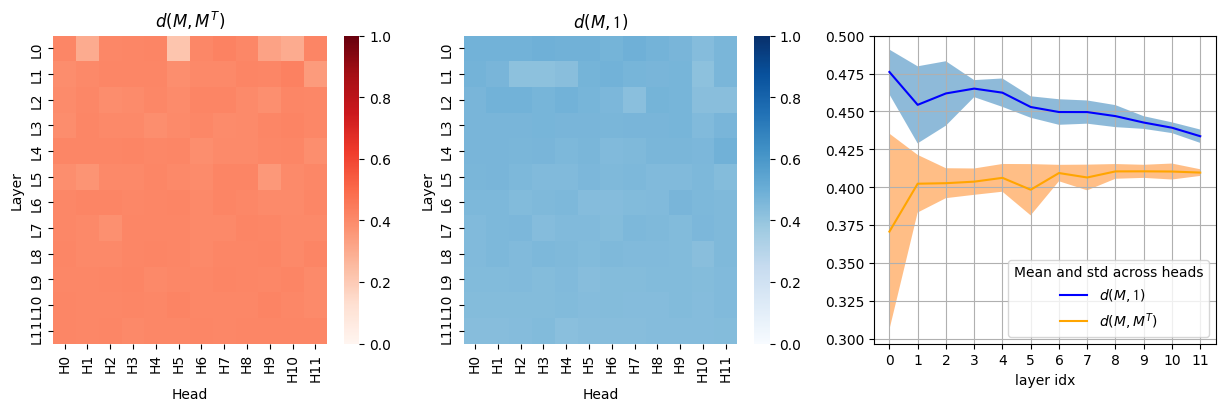

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set aesthetic

fig, axs = plt.subplots(nrows = 1, ncols = 3, figsize = (15, 4))

def plot_heatmap(data, ax, title, cmap="viridis"):
    sns.heatmap(data,ax = ax, annot=False, cmap=cmap, cbar=True,
                     xticklabels=[f"H{h}" for h in range(num_heads)],
                     yticklabels=[f"L{l}" for l in range(layer_max)], vmin = 0, vmax = 1)
    ax.set_xlabel("Head")
    ax.set_ylabel("Layer")
    ax.set_title(title)

# Visualizations
plot_heatmap(dist_T_scaled, axs[0], r"$d(M,M^T)$", cmap="Reds")
plot_heatmap(dist_id_scaled, axs[1], r"$d(M, \mathcal{1})$", cmap="Blues")



mean = np.mean(dist_id_scaled, axis = 1)
std = np.std(dist_id_scaled, axis = 1)
axs[2].plot(np.arange(0, layer_max ), mean, color= "blue", label = r"$ d(M, \mathcal{1})$")
axs[2].fill_between(np.arange(0, layer_max ), y1 = mean - std, alpha = 0.5, y2 = mean + std)


mean = np.mean(dist_T_scaled, axis = 1)
std = np.std(dist_T_scaled, axis = 1)
axs[2].plot(np.arange(0, layer_max ), mean, color = "orange", label = r"$ d(M, M^T)$")
axs[2].fill_between(np.arange(0, layer_max), y1 = mean - std, alpha = 0.5, y2 = mean + std)

axs[2].set_xlabel("layer idx")
axs[2].set_xticks(np.arange(0, 12))
axs[2].legend(title = "Mean and std across heads")
axs[2].grid()


### Visualization of absolute norms of the W matrices, layer per layer


The complete W-s are doing a change of basis in R^D. Then, the splitting in heads takes projections over subspaces of dim <= d_h.

So lets look at this change of basis.

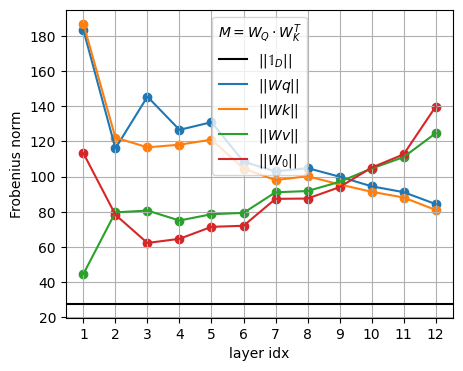

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4))
plt.subplots_adjust(hspace = 0.3)


ax.axhline(y = norm(np.eye(D)), color = "black", label = r"$||\mathbb{1}_D||$")


ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wq] , label = r"$||Wq||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wq])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wk], label = r"$||Wk||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wk])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in Wv], label = r"$||Wv||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in Wv])

ax.plot(np.arange(1, layer_max + 1), [norm(w) for w in W0], label = r"$||W_0||$")
ax.scatter(np.arange(1, layer_max + 1), [norm(w) for w in W0])

ax.grid()
ax.set_xlabel("layer idx")
ax.set_ylabel("Frobenius norm")
ax.set_xticks(np.arange(1, 13))
ax.legend(title = r"$M = W_Q\cdot W_K^T$")

### 3. Computing ranks of the transformation matrices.

$W_Q, W_K, W_V, W_0$ : are they projections or change of basis?


Do they preserve distances? Do they preserve angles?

In [12]:
import numpy as np

q_rank = [np.linalg.matrix_rank(q) for q in Wq]
k_rank = [np.linalg.matrix_rank(k) for k in Wk]
v_rank = [np.linalg.matrix_rank(v) for v in Wv]
w0_rank = [np.linalg.matrix_rank(w0) for w0 in W0]

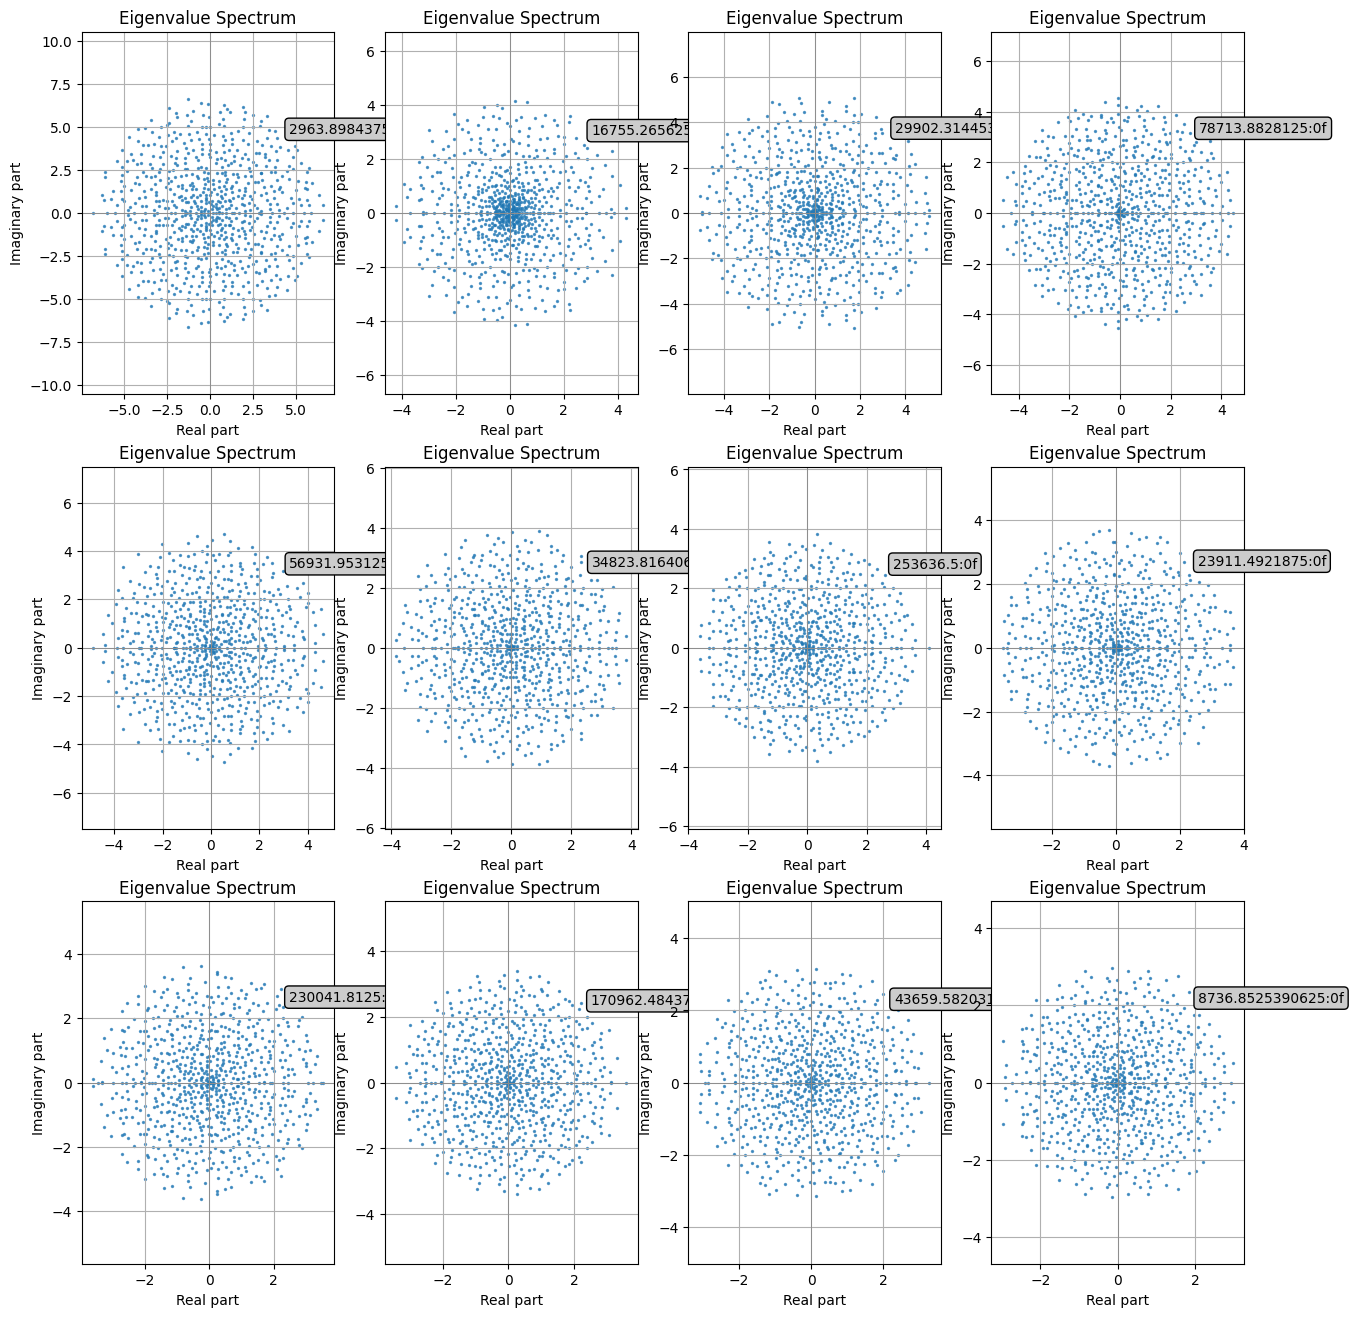

In [37]:
fig, axs = plt.subplots(nrows = 3, ncols = 4, figsize=(5*3,4*4))
axs = axs.flatten()

bbox = dict(boxstyle="round", fc="0.8")

for i in range(0, layer_max):

    A = q_weights[i]
    eigvals = np.linalg.eigvals(A)
    cond_number = np.linalg.cond(A)
    axs[i].annotate(text= f"{cond_number}:0f", xy = (max(eigvals.real)*0.7, max(eigvals.imag)*0.7), bbox = bbox)
    axs[i].scatter(eigvals.real, eigvals.imag, s=2, alpha=0.7)
    axs[i].axhline(0, color='gray', linewidth=0.5)
    axs[i].axvline(0, color='gray', linewidth=0.5)
    axs[i].set_xlabel('Real part')
    axs[i].set_ylabel('Imaginary part')
    axs[i].set_title('Eigenvalue Spectrum')
    axs[i].grid(True)
    axs[i].axis('equal')


You’re likely observing:
- A linear transformation that scrambles the space, mixing directions with complex shearing, non-uniform scaling, and non-normal behavior.
- The fact that eigenvalues are inside a disk (not just on the unit circle) means it compresses some directions (i.e., not volume-preserving).

So: the circle is not a “structured” geometric transformation like rotation or scaling — it’s a signature of randomness and loss of geometric meaning.

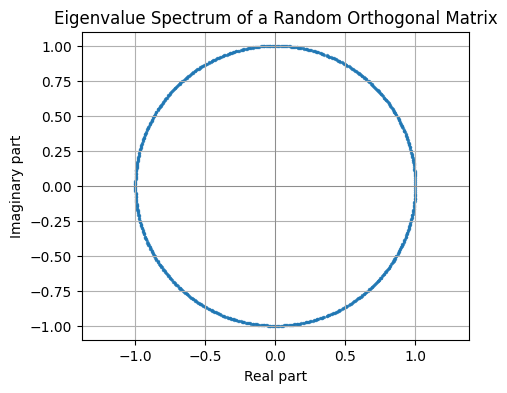

In [29]:

# Step 1: Generate a random matrix
A = np.random.randn(789, 789)
Q, R = np.linalg.qr(A)
# Q is now orthogonal: Q.T @ Q ≈ I
eigvals = np.linalg.eigvals(Q)

plt.figure(figsize=(5,4))
plt.scatter(eigvals.real, eigvals.imag, s=2, alpha=0.7)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('Eigenvalue Spectrum of a Random Orthogonal Matrix')
plt.grid(True)
plt.axis('equal')
plt.show()

Is A orthogonal? False
Condition number: 2963.8984


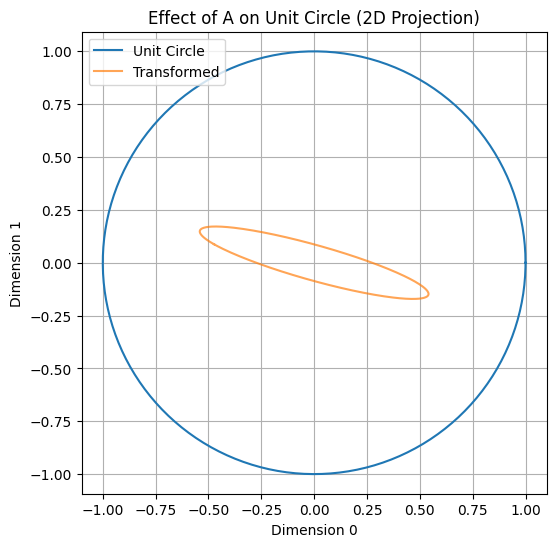

In [31]:
A = q_weights[0]
n = A.shape[0]
# 1. ✅ Check if A is orthogonal
is_orthogonal = np.allclose(A.T @ A, np.eye(n), atol=1e-6)
print("Is A orthogonal?", is_orthogonal)

# 2. ✅ Condition number (ratio of largest to smallest singular value)
cond_number = np.linalg.cond(A)
print("Condition number:", cond_number)

# 3. ✅ Visualize transformation of unit sphere

# Pick a 2D plane (e.g. first 2 dimensions)
dim1, dim2 = 0, 1
num_points = 300

# Generate points on unit circle in 2D subspace
theta = np.linspace(0, 2*np.pi, num_points)
unit_circle = np.zeros((n, num_points))
unit_circle[dim1, :] = np.cos(theta)
unit_circle[dim2, :] = np.sin(theta)

# Transform the circle with A
transformed = A @ unit_circle

# Plot
plt.figure(figsize=(6,6))
plt.plot(unit_circle[dim1], unit_circle[dim2], label='Unit Circle')
plt.plot(transformed[dim1], transformed[dim2], label='Transformed', alpha=0.7)
plt.xlabel(f"Dimension {dim1}")
plt.ylabel(f"Dimension {dim2}")
plt.title("Effect of A on Unit Circle (2D Projection)")
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

📈 Condition number ≈ 2964 (not terrible, but not great)
	•	This measures how much the matrix distorts space.
	•	A condition number ≈ 1 means near-orthogonal (ideal).
	•	Your value suggests some directions are stretched ~3000× more than others, but it’s not catastrophic (e.g., not 10^8).

📐 Transformed unit circle = ellipse
	•	Confirms that some directions are amplified, others are compressed.
	•	Geometrically, your matrix is a non-uniform linear transformation — likely combining rotation + anisotropic scaling.

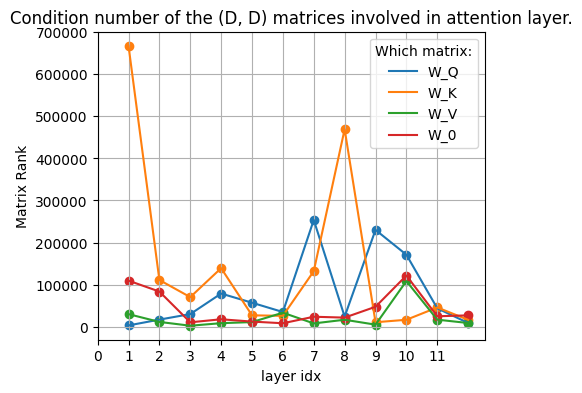

In [39]:
q_number = [np.linalg.cond(A) for A in q_weights]
k_number = [np.linalg.cond(A) for A in k_weights]
v_number = [np.linalg.cond(A) for A in v_weights]
w0_number = [np.linalg.cond(A) for A in w0_weights]



fig, axs = plt.subplots(nrows = 1, ncols = 1, figsize=(5, 4))




axs.plot(np.arange(1, layer_max + 1), q_number, label = "W_Q")
axs.scatter(np.arange(1, layer_max + 1), q_number)

axs.plot(np.arange(1, layer_max + 1), k_number, label = "W_K")
axs.scatter(np.arange(1, layer_max + 1), k_number)

axs.plot(np.arange(1, layer_max + 1), v_number, label = "W_V")
axs.scatter(np.arange(1, layer_max + 1), v_number)

axs.plot(np.arange(1, layer_max + 1), w0_number, label = "W_0")
axs.scatter(np.arange(1, layer_max + 1), w0_number)



axs.grid()
axs.set_title("Condition number of the (D, D) matrices involved in attention layer.")
axs.set_xlabel("layer idx")
axs.set_ylabel("Matrix Rank")
axs.set_xticks(np.arange(0, 12))

axs.legend(title = "Which matrix:")

🧠 What does this mean?

A condition number ≈ 10^5 means:
	•	W_Q stretches some directions 100,000× more than others
	•	It is very sensitive to input perturbations in X
	•	In geometric terms: the input space is squashed along some directions and exploded along others

⸻

🧬 Why does this matter for attention?

1. Q = X·W_Q projects inputs into “query space”
	•	A poorly conditioned W_Q means:
	•	Small variations in X may lead to large or unstable differences in Q
	•	Some directions in the input are essentially ignored (near-zero amplification)
	•	Others dominate (over-amplified)


# Understanding how non symmetric matrices act on R^D

[3.65028154 0.82185442]


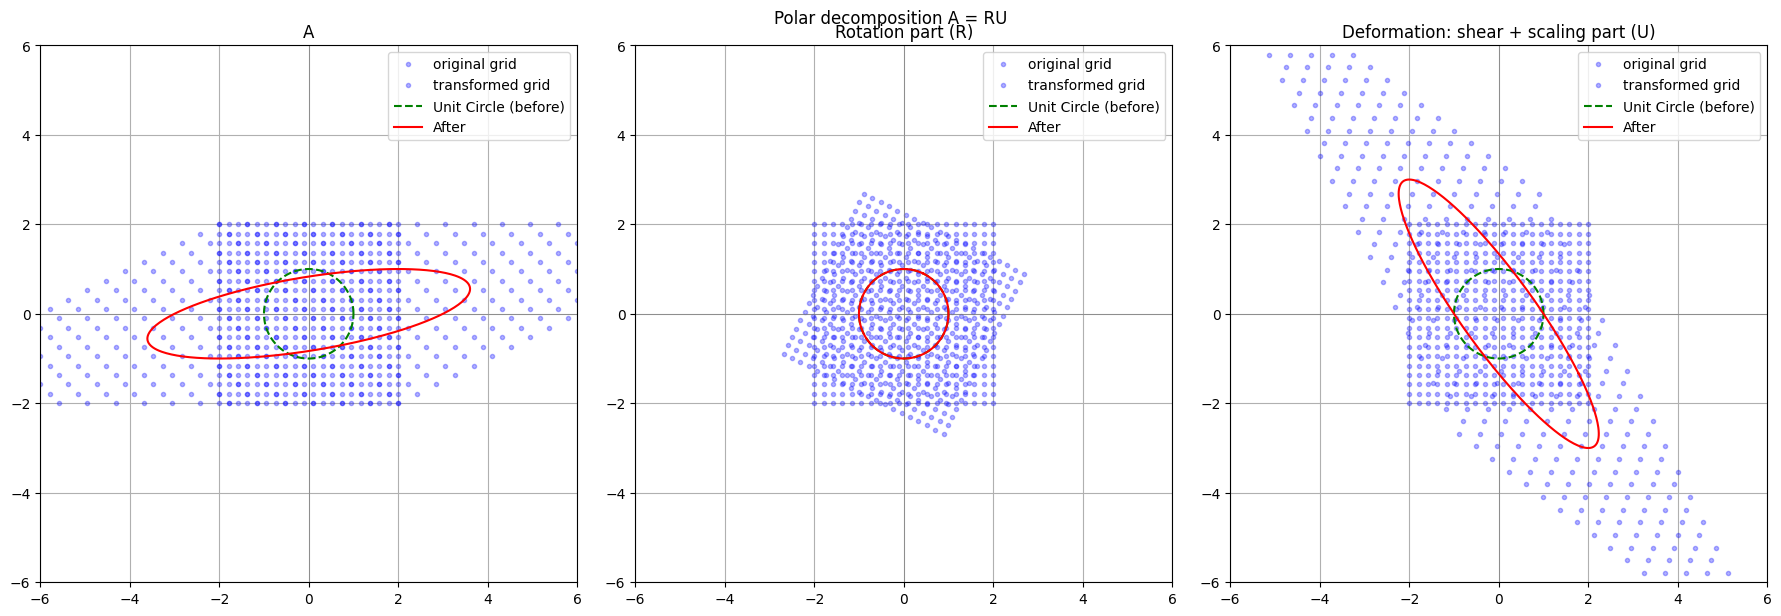

In [ ]:
import numpy as np
from scipy.linalg import polar, svd

# Define the matrix A
A = np.array([[2, -3],
              [1,  0]])

# Compute the polar decomposition: A = R @ U
R, U = polar(A)

# Compute the singular value decomposition: A = U_svd @ Sigma @ Vt
U_svd, Sigma, Vt = svd(A)
Sigma_matrix = np.zeros_like(A)
np.fill_diagonal(Sigma_matrix, Sigma)

print(Sigma)



R_polar = R
U_polar = U

{
    "A": A,
    "Polar_Decomposition": {"R (rotation/reflection)": R_polar, "U (symmetric, scaling+shear)": U_polar},
    "SVD": {
        "U (output rotation)": U_svd,
        "Sigma (scaling)": Sigma_matrix,
        "Vt (input rotation transpose)": Vt
    }
}


import matplotlib.pyplot as plt

def plot_transformation(matrix, title, ax):
    # Define a grid and a unit circle
    grid_range = np.linspace(-2, 2, 20)
    X, Y = np.meshgrid(grid_range, grid_range)
    grid_points = np.vstack([X.ravel(), Y.ravel()])
    transformed_grid = matrix @ grid_points

    # Plot transformed grid
    ax.plot(grid_points[0], grid_points[1], 'b.', alpha=0.3, label = "original grid")
    ax.plot(transformed_grid[0], transformed_grid[1], 'b.', alpha=0.3, label = "transformed grid")
    ax.set_aspect('equal')
    ax.set_title(title)
    ax.grid(True)
    ax.axhline(0, color='gray', lw=0.5)
    ax.axvline(0, color='gray', lw=0.5)
    ax.set_xlim(-6, 6)
    ax.set_ylim(-6, 6)

    # Unit circle before and after transformation
    theta = np.linspace(0, 2 * np.pi, 300)
    circle = np.vstack([np.cos(theta), np.sin(theta)])
    transformed_circle = matrix @ circle
    ax.plot(circle[0], circle[1], 'g--', label='Unit Circle (before)')
    ax.plot(transformed_circle[0], transformed_circle[1], 'r-', label='After')
    ax.legend(loc='upper right')

# Plot transformations
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

plt.suptitle("Polar decomposition A = RU")
plot_transformation(A, 'A', axs[0])
plot_transformation(R, 'Rotation part (R)', axs[1])
plot_transformation(U, 'Deformation: shear + scaling part (U)', axs[2])

plt.tight_layout()
plt.show()



[[3 0]
 [0 0]]
[[ 1.73148057 -2.40230096]
 [ 0.28098061 -0.38983978]]
[[ 2 -3]
 [ 1  0]]


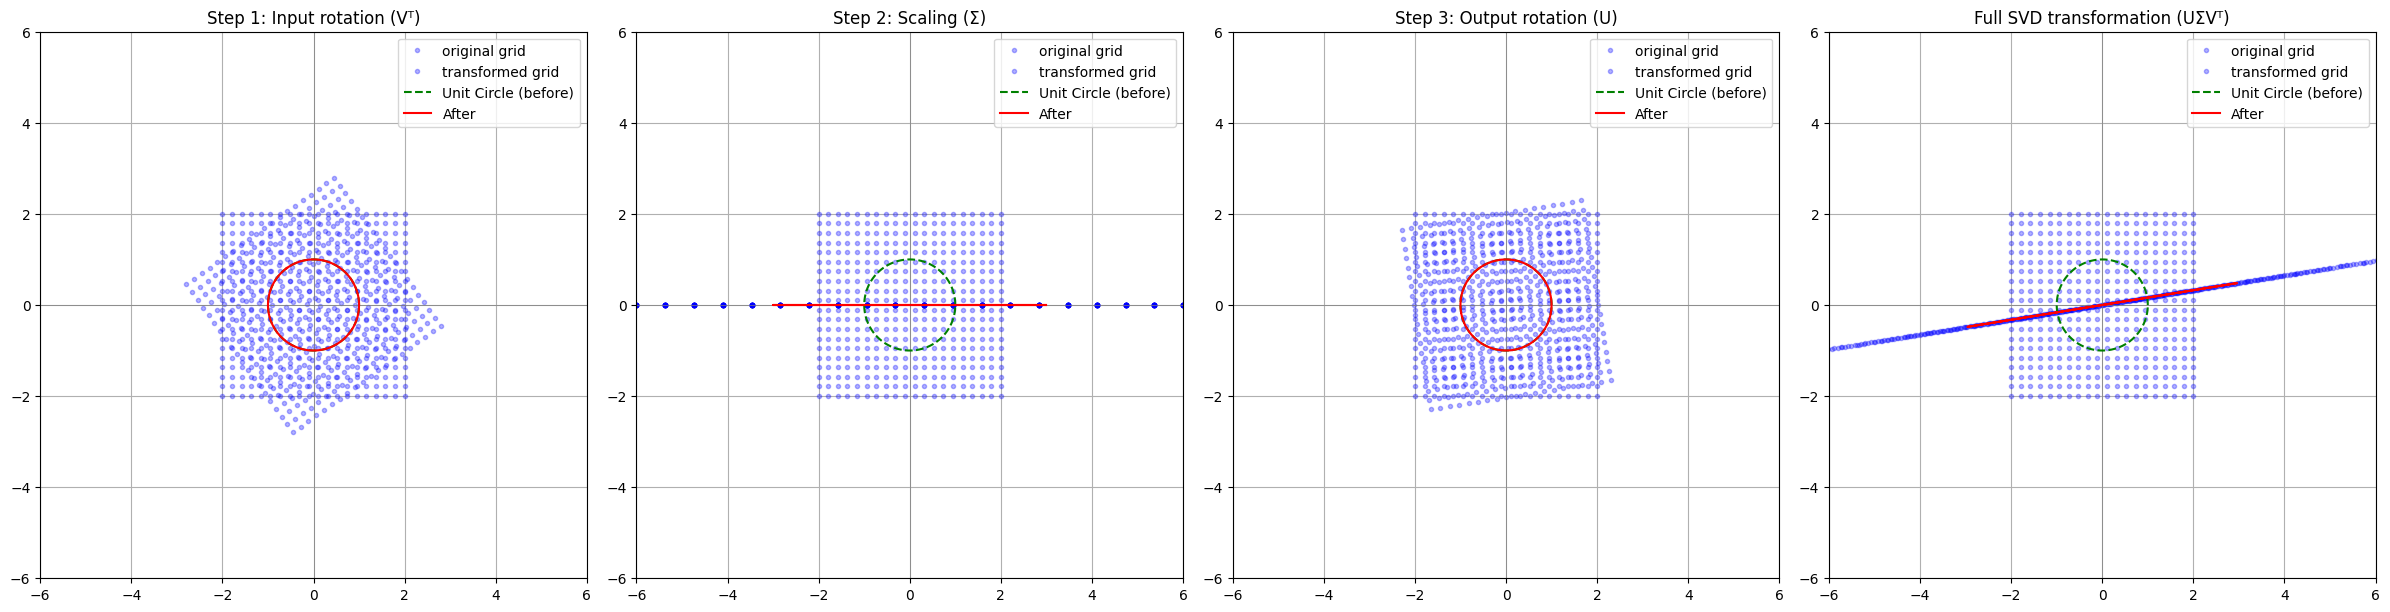

In [24]:
# Compute the singular value decomposition: A = U_svd @ Sigma @ Vt
U_svd, Sigma, Vt = svd(A)
Sigma_matrix = np.zeros_like(A)
np.fill_diagonal(Sigma_matrix, Sigma)
print(Sigma_matrix)

a_reconstructed = U_svd @ Sigma_matrix @ Vt
print(a_reconstructed)
print(A)

# Compose each stage of the transformation
stage1 = Vt        # Rotate input
stage2 = Sigma_matrix # Scale
stage3 = U_svd       # Rotate output

# Combined steps
A_svd = stage3 @ stage2 @ stage1

# Plot each stage
fig, axs = plt.subplots(1, 4, figsize=(24, 6))

plot_transformation(stage1, 'Step 1: Input rotation (Vᵀ)', axs[0])
plot_transformation(stage2, 'Step 2: Scaling (Σ)', axs[1])
plot_transformation(stage3, 'Step 3: Output rotation (U)', axs[2])
plot_transformation(A_svd, 'Full SVD transformation (UΣVᵀ)', axs[3])

plt.tight_layout()
plt.show()